In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from transformers import pipeline, AutoTokenizer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils, models
import scipy.sparse
from wordcloud import WordCloud
from text_processing import preprocess_data
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

/Data/thibaud.gloaguen/micromamba/envs/gess/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data 🕐

In [2]:
df = pd.read_csv("bitcoin_2022/submission.csv")

# Pre-processing
df = preprocess_data(df)

columns_to_keep = ["upvote_ratio", "score", "total_awards_received", "num_comments", "selftext", "author"]
df = df[columns_to_keep]

# LDA labelling 💪

In [38]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

def strip_down_string(text: str):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # Join words back into one string separated by space
    return ' '.join(words)

def lda_topics(dataframe, k, text_column: str):

    # Creating the document-term matrix
    cv = CountVectorizer(stop_words='english')
    data_cv = cv.fit_transform(dataframe[text_column])
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
    data_dtm.index = dataframe.index
    
    # Converting the document-term matrix into a gensim format corpus
    corpus = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtm.transpose()))
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())
    
    # LDA model
    lda = models.LdaModel(corpus=corpus, num_topics=k, id2word=id2word, passes=10)
    
    # Assign topics and their probabilities
    topic_probabilities = []
    for doc in corpus:
        # Get the topic distribution for the document
        doc_topics = lda.get_document_topics(doc, minimum_probability=0)
        doc_prob_dict = dict(doc_topics)
        # Fill in missing probabilities if any topic has probability 0
        topic_probs = [doc_prob_dict.get(i, 0) for i in range(k)]
        topic_probabilities.append(topic_probs)
    
    # Creating columns for each topic's probability
    for i in range(k):
        dataframe[f'topic_{i}_prob'] = [probs[i] for probs in topic_probabilities]
    
    # Assign the most probable topic to a separate column
    dataframe['topic'] = dataframe.apply(lambda row: max((row[f'topic_{i}_prob'], i) for i in range(k))[1], axis=1)
    
    return dataframe, lda, corpus, id2word


def plot_word_clouds(lda_model, id2word, k, ncols=5, topic_names=None):
    nrows = (k // ncols) + (k % ncols > 0)  # Calculate the required number of rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))  # Adjust the size as needed
    
    axes = axes.flatten()  # Flatten the array to easily loop over it
    for i in range(k):
        ax = axes[i]
        wc = WordCloud(background_color='white', max_words=1000)
        # Extracting words and their weights for each topic
        terms = {id2word[word_id]: weight for word_id, weight in lda_model.get_topic_terms(i, topn=10)}
        wc.generate_from_frequencies(terms)
        ax.imshow(wc, interpolation='bilinear')
        ax.axis("off")
        
        if topic_names is not None:
            ax.set_title(topic_names[i])
        else:  
            ax.set_title(f'Topic #{i + 1}')

    # Turn off any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-b/2020/thibaud.gloaguen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-b/2020/thibaud.gloaguen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df["processed_text"] = df["selftext"].apply(strip_down_string)

In [ ]:
n_topic = 10
df, lda_model, corpus, id2word = lda_topics(df, n_topic, text_column = "processed_text")

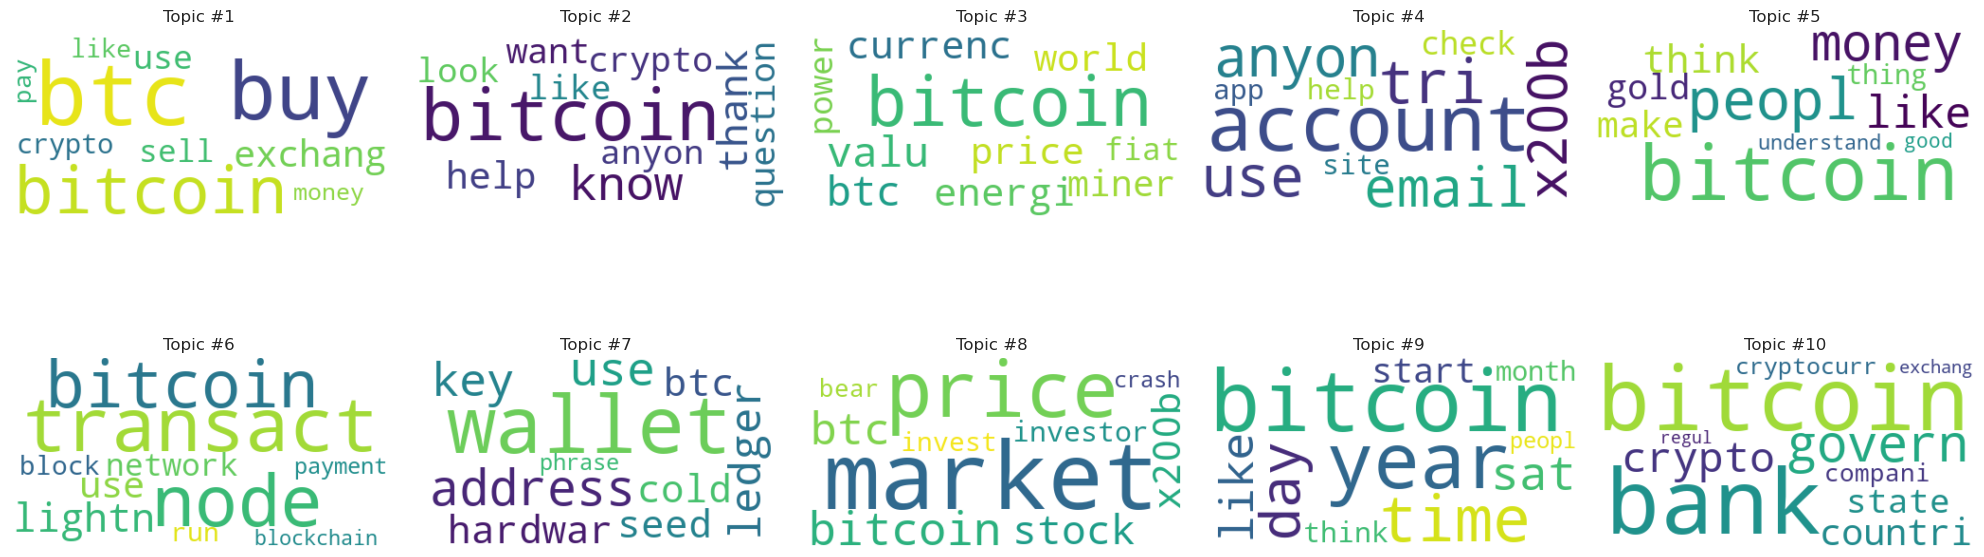

In [39]:
plot_word_clouds(lda_model, id2word, n_topic)

Making a pie chart of the topic

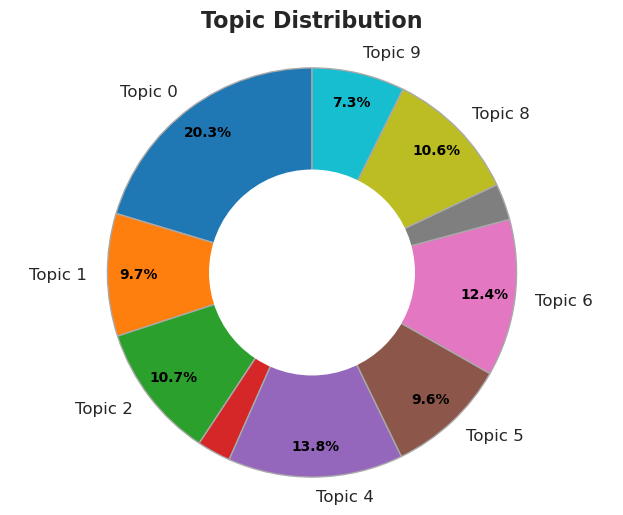

In [43]:
def plot_topic_distribution(dataframe, topic_names=None):
    # Count the frequency of each topic
    topic_counts = dataframe['topic'].value_counts()
    # Sort the topics by topic number (assuming topic numbers are in order)
    topic_counts = topic_counts.sort_index()
    
    # Subtle color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    fig, ax = plt.subplots()
    
    # Calculate percentages and prepare labels, show percentages only if significant
    percentages = 100. * topic_counts / topic_counts.sum()
    labels = [f'Topic {i}' if percent > 5 else '' for i, percent in zip(topic_counts.index, percentages)]
    wedges, texts, autotexts = ax.pie(topic_counts, labels=labels,
                                      autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
                                      startangle=90, colors=colors, wedgeprops={'edgecolor': 'darkgrey'},
                                      pctdistance=0.85)
    
    
    # Smaller inner circle for a subtle donut look
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig.gca().add_artist(centre_circle)
    
    # Increase the size and weight of the autotexts and adjust label colors for better readability
    plt.setp(autotexts, size=10, weight="bold", color="black")
    plt.setp(texts, size=12)
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')  
    plt.tight_layout()
    
    # Adjust the title to avoid overlap and improve aesthetic
    plt.title('Topic Distribution', fontsize=16, fontweight='bold', pad=20)
    plt.show()

# Assuming `df` is your DataFrame containing a 'topic' column
plot_topic_distribution(df)

# Automatically titled topics 😎

Here I use mistral so only do that if you have a (good) GPU

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

# Configuring the model with quantization for efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
    )

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

In [14]:


def generate_titles(lda_model, id2word, num_topics):
    titles = []
    for i in range(num_topics):
        # Extract the top 10 words for the topic
        topic_words = [id2word[word_id] for word_id, _ in lda_model.get_topic_terms(i, topn=10)]
        topic_description = ", ".join(topic_words)
        
        # Generating a prompt for the model
        prompt = f"A concise, catchy title for a discussion about these keywords: {topic_description} that is less than 5 words is:"
        
        # Tokenizing the prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        
        # Generating output
        outputs = model.generate(**inputs, max_length=50 + len(prompt), num_beams=5, early_stopping=True)
        
        # Decoding the generated text and removing the prompt part
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        title = full_text[len(prompt):].strip()  # Remove the prompt and extra whitespace
        
        titles.append(title)
    
    return titles

# Assuming lda_model and id2word are already defined and you have 5 topics
titles = generate_titles(lda_model, id2word, 5)
print(titles)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['"Bitcoin vs. Fiat: People\'s Value in a World of Inflation"\n\n---\n\n**Bitcoin vs. Fiat: People\'s Value in a World of Inflation**\n\nIn today\'s global economy, two primary forms of currency dominate the financial landscape: bitcoin and fiat currency. While both serve as mediums of exchange, their underlying structures, values, and implications for people differ significantly.\n\n**Bitcoin**\n\nBitcoin is a decentralized digital currency, created in 2009 by an unknown person or group using the pseudonym Satoshi Nakamoto. Unlike traditional fiat currencies, which are issued and controlled by governments or central banks, bitcoin operates on a decentralized peer-to-peer network.', '"EU Miners\' Electricity Costs: Coldcard vs. Bitfinex"\n\nTitle: EU Miners\' Electricity Costs: Coldcard vs. Bitfinex\n\nIntroduction:\nEuropean Union (EU) miners face unique challenges when it comes to electricity costs, which can significantly impact their profitability. In this discussion, we will compa